In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/CS 415 Project'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1vr_n2c2jn4NS6hWYwfSFpVQv7RAcwhSK/CS 415 Project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, Nadam
import matplotlib.pyplot as plt
import random
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset Preprocessing

In [ ]:
def create_df_with_validation(dataset_dir, classes):
    image_paths = []
    labels = []

    for cls in classes:
        cls_dir = os.path.join(dataset_dir, cls)
        for img_file in os.listdir(cls_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(cls_dir, img_file))
                labels.append(cls)

    df = pd.DataFrame({'filename': image_paths, 'class': labels})
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
    train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['class'])  # 0.25 x 0.8 = 0.2
    return train_df, val_df, test_df

covid_classes = ['Viral Pneumonia', 'Normal', 'Lung_Opacity', 'COVID']
train_df_covid, val_df_covid, test_df_covid = create_df_with_validation("Filtered_COVID_Dataset_7000", covid_classes)

mnist_classes = ['HeadCT', 'AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand']
train_df_mnist, val_df_mnist, test_df_mnist = create_df_with_validation("Filtered_Medical_MNIST_7000", mnist_classes)

In [ ]:
def create_generators(train_df, val_df, test_df, img_height=224, img_width=224, batch_size=16):
    datagen_train = ImageDataGenerator(rescale=1.0/255)
    datagen_val_test = ImageDataGenerator(rescale=1.0/255)

    train_generator = datagen_train.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = datagen_val_test.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = datagen_val_test.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

covid_train_generator, covid_val_generator, covid_test_generator = create_generators(
    train_df_covid, val_df_covid, test_df_covid)

mnist_train_generator, mnist_val_generator, mnist_test_generator = create_generators(
    train_df_mnist, val_df_mnist, test_df_mnist)


Found 3957 validated image filenames belonging to 4 classes.
Found 1319 validated image filenames belonging to 4 classes.
Found 1319 validated image filenames belonging to 4 classes.
Found 4200 validated image filenames belonging to 6 classes.
Found 1401 validated image filenames belonging to 6 classes.
Found 1401 validated image filenames belonging to 6 classes.


In [ ]:
def print_dataset_summary(generator, name):
    print(f"Dataset: {name}")
    print(f" - Classes: {generator.class_indices}")
    print(f" - Total samples: {generator.n}")

print_dataset_summary(covid_train_generator, "COVID Training")
print_dataset_summary(mnist_train_generator, "MNIST Training")

Dataset: COVID Training
 - Classes: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
 - Total samples: 3957
Dataset: MNIST Training
 - Classes: {'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}
 - Total samples: 4200


In [ ]:
def compute_weights(train_df, class_labels):
    train_df['class_idx'] = train_df['class'].map({cls: idx for idx, cls in enumerate(class_labels)})
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['class_idx']),
        y=train_df['class_idx']
    )
    return dict(enumerate(weights))

covid_weights = compute_weights(train_df_covid, covid_classes)
mnist_weights = compute_weights(train_df_mnist, mnist_classes)

# Compare models

In [ ]:
model_dir = "./Snigdha"

In [ ]:

covid_adam_model = load_model(os.path.join(model_dir, "resnet-97ac.keras"))
print(" COVID Model (Adam) loaded successfully!")
covid_nadam_model = load_model(os.path.join(model_dir, "nadam-95.keras"))
print(" COVID Model (Nadam) loaded successfully!")
mnist_adam_model = load_model(os.path.join(model_dir, "mnist-adam.keras"))
print(" MNIST Model (Adam) loaded successfully!")
mnist_nadam_model = load_model(os.path.join(model_dir, "nadam-mnist-99.keras"))
print(" MNIST Model (Nadam) loaded successfully!")
print()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 218 variables whereas the saved optimizer has 434 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 COVID Model (Adam) loaded successfully!
 COVID Model (Nadam) loaded successfully!
 MNIST Model (Adam) loaded successfully!
 MNIST Model (Nadam) loaded successfully!



In [ ]:
def eval_adv():
    covid_adam_test_loss, covid_adam_test_accuracy = covid_adam_model.evaluate(covid_test_generator)
    print(f"COVID Model (Adam) - Test Loss: {covid_adam_test_loss:.4f}, Test Accuracy: {covid_adam_test_accuracy:.4f}")

    covid_nadam_test_loss, covid_nadam_test_accuracy = covid_nadam_model.evaluate(covid_test_generator)
    print(f"COVID Model (Nadam) - Test Loss: {covid_nadam_test_loss:.4f}, Test Accuracy: {covid_nadam_test_accuracy:.4f}")

    mnist_adam_test_loss, mnist_adam_test_accuracy = mnist_adam_model.evaluate(mnist_test_generator)
    print(f"MNIST Model (Adam) - Test Loss: {mnist_adam_test_loss:.4f}, Test Accuracy: {mnist_adam_test_accuracy:.4f}")

    mnist_nadam_test_loss, mnist_nadam_test_accuracy = mnist_nadam_model.evaluate(mnist_test_generator)
    print(f"MNIST Model (Nadam) - Test Loss: {mnist_nadam_test_loss:.4f}, Test Accuracy: {mnist_nadam_test_accuracy:.4f}")
eval_adv()

73/73 ━━━━━━━━━━━━━━━━━━━━ 464s 6s/step - accuracy: 0.7794 - loss: 0.7331


KeyboardInterrupt: 

In [ ]:
covid_adam_loss, covid_adam_accuracy = covid_adam_model.evaluate(covid_train_generator, verbose=1)
print(f"Training Accuracy: {covid_adam_accuracy * 100:.2f}%")
print("\n")

covid_nadam_loss, covid_nadam_accuracy = covid_nadam_model.evaluate(covid_train_generator, verbose=1)
print(f"Training Accuracy: {covid_nadam_accuracy * 100:.2f}%")
print("\n")

mnist_adam_loss, mnist_adam_accuracy = mnist_adam_model.evaluate(mnist_train_generator, verbose=1)
print(f"Training Accuracy: {mnist_adam_accuracy * 100:.2f}%")
print("\n")

mnist_nadam_loss, mnist_nadam_accuracy = mnist_nadam_model.evaluate(mnist_train_generator, verbose=1)
print(f"Training Accuracy: {mnist_nadam_accuracy * 100:.2f}%")
print("\n")

248/248 ━━━━━━━━━━━━━━━━━━━━ 805s 3s/step - accuracy: 0.9487 - loss: 0.1663
Training Accuracy: 94.47%


 64/248 ━━━━━━━━━━━━━━━━━━━━ 8:58 3s/step - accuracy: 0.8602 - loss: 0.3687

KeyboardInterrupt: 

In [ ]:
covid_adam_history = covid_adam_model.fit(covid_train_generator, epochs=7, class_weight=covid_weights,validation_data=covid_val_generator)
print("\n")
covid_nadam_history = covid_nadam_model.fit(covid_train_generator, epochs=7, class_weight=covid_weights,validation_data=covid_val_generator)
print("\n")
mnist_adam_history = mnist_adam_model.fit(mnist_train_generator, epochs=7, class_weight=mnist_weights ,validation_data=mnist_val_generator)
print("\n")
mnist_nadam_history = mnist_nadam_model.fit(mnist_train_generator, epochs=7, class_weight=mnist_weights, validation_data=mnist_val_generator)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 1647s 7s/step - accuracy: 0.9276 - loss: 0.2459 - val_accuracy: 0.3716 - val_loss: 2.4653
Epoch 2/7
218/218 ━━━━━━━━━━━━━━━━━━━━ 55s 197ms/step - accuracy: 0.9393 - loss: 0.1763 - val_accuracy: 0.8603 - val_loss: 0.3784
Epoch 3/7
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 203ms/step - accuracy: 0.9539 - loss: 0.1387 - val_accuracy: 0.4560 - val_loss: 3.8914
Epoch 4/7
218/218 ━━━━━━━━━━━━━━━━━━━━ 78s 187ms/step - accuracy: 0.9661 - loss: 0.0926 - val_accuracy: 0.7690 - val_loss: 0.6550
Epoch 5/7
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.9704 - loss: 0.0986 - val_accuracy: 0.5379 - val_loss: 1.2440
Epoch 6/7
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.9742 - loss: 0.0857 - val_accuracy: 0.9147 - val_loss: 0.2823
Epoch 7/7
218/218 ━━━━━━━━━━━━━━━━━━━━ 46s 206ms/step - accuracy: 0.9726 - loss: 0.0858 - val_accuracy: 0.7638 - val_loss: 0.7388


Epoch 1/7
218/218 ━━━━━━━━━━━━━━━━━━━━ 135s 348ms/step - accuracy: 0.9330 - loss: 0.2124 - val_accu

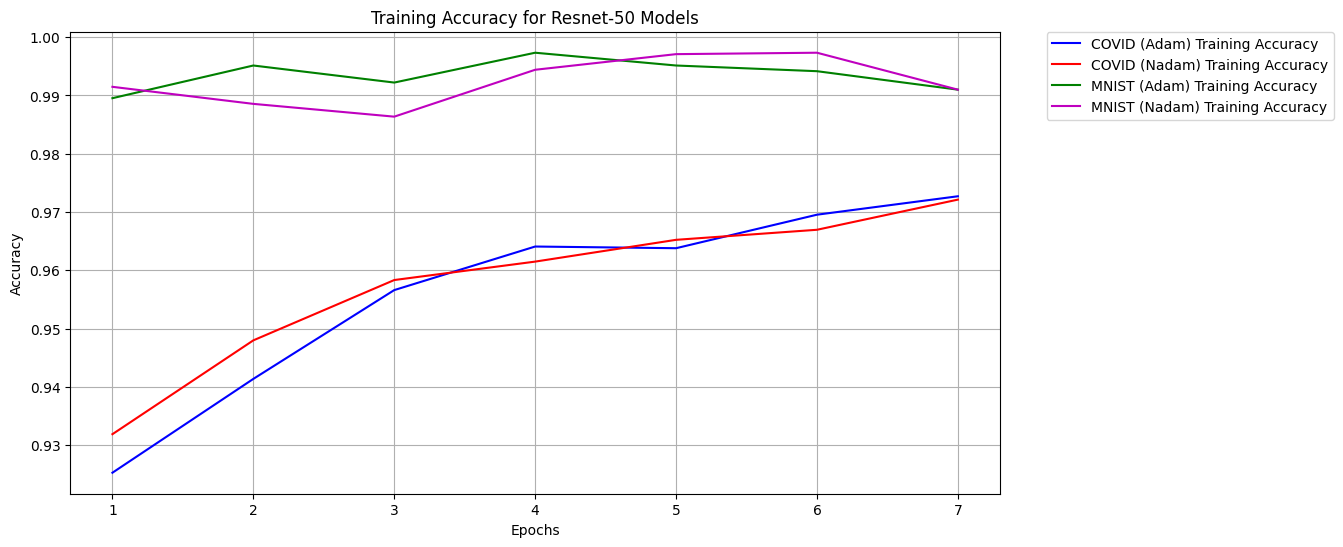

In [ ]:
def plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history):

    covid_adam_acc = covid_adam_history.history['accuracy']
    # covid_adam_val_acc = covid_adam_history.history['val_accuracy']
    # covid_adam_loss = covid_adam_history.history['loss']
    # covid_adam_val_loss = covid_adam_history.history['val_loss']
    covid_nadam_acc = covid_nadam_history.history['accuracy']
    # covid_nadam_val_acc = covid_nadam_history.history['val_accuracy']
    # covid_nadam_loss = covid_nadam_history.history['loss']
    # covid_nadam_val_loss = covid_nadam_history.history['val_loss']
    mnist_adam_acc = mnist_adam_history.history['accuracy']
    # mnist_adam_val_acc = mnist_adam_history.history['val_accuracy']
    # mnist_adam_loss = mnist_adam_history.history['loss']
    # mnist_adam_val_loss = mnist_adam_history.history['val_loss']
    mnist_nadam_acc = mnist_nadam_history.history['accuracy']
    # mnist_nadam_val_acc = mnist_nadam_history.history['val_accuracy']
    # mnist_nadam_loss = mnist_nadam_history.history['loss']
    # mnist_nadam_val_loss = mnist_nadam_history.history['val_loss']
    epochs = range(1, len(covid_adam_acc) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, covid_adam_acc, 'b-', label='COVID (Adam) Training Accuracy')
    plt.plot(epochs, covid_nadam_acc, 'r-', label='COVID (Nadam) Training Accuracy')
    plt.plot(epochs, mnist_adam_acc, 'g-', label='MNIST (Adam) Training Accuracy')
    plt.plot(epochs, mnist_nadam_acc, 'm-', label='MNIST (Nadam) Training Accuracy')
    plt.title('Training Accuracy for Resnet-50 Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()
    # plt.figure(figsize=(12, 6))
    # plt.plot(epochs, covid_adam_loss, 'b--', label='COVID (Adam) Training Loss')
    # plt.plot(epochs, covid_nadam_loss, 'r--', label='COVID (Nadam) Training Loss')
    # plt.plot(epochs, mnist_adam_loss, 'g--', label='MNIST (Adam) Training Loss')
    # plt.plot(epochs, mnist_nadam_loss, 'm--', label='MNIST (Nadam) Training Loss')
    # plt.title('Training Loss for Resnet50 Transfer Learning Models')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.grid(True)
    # plt.show()

plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history)


# DO NOT RUN ----- RESNET-50 (overfitting)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
def build_resnet_model(input_shape=(128, 128, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)
    base_model.trainable=True
    return model

# Initialize model
model = build_resnet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Train model

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model structure
# model.summary()

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    covid_train_generator,
    validation_data=covid_val_generator,
    epochs=15,
    class_weight=covid_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 2098s 8s/step - accuracy: 0.6928 - loss: 0.9957 - val_accuracy: 0.2654 - val_loss: 6.5880 - learning_rate: 0.0010
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 94s 149ms/step - accuracy: 0.8364 - loss: 0.4533 - val_accuracy: 0.2654 - val_loss: 6.1671 - learning_rate: 0.0010
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - accuracy: 0.8611 - loss: 0.3837 - val_accuracy: 0.3768 - val_loss: 1.3652 - learning_rate: 0.0010
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.8923 - loss: 0.2884 - val_accuracy: 0.4534 - val_loss: 1.6620 - learning_rate: 0.0010
Epoch 5/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.9166 - loss: 0.2385 - val_accuracy: 0.6983 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 6/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.9348 - loss: 0.1624 - val_accuracy: 0.6778 - val_loss: 0.7139 - learning_rate: 0.0010
Epoch 7/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 43s 154ms/step - accuracy: 0.9313 - loss: 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(covid_test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 512s 6s/step - accuracy: 0.9052 - loss: 0.3391
Test Loss: 0.404382586479187, Test Accuracy: 0.8923426866531372


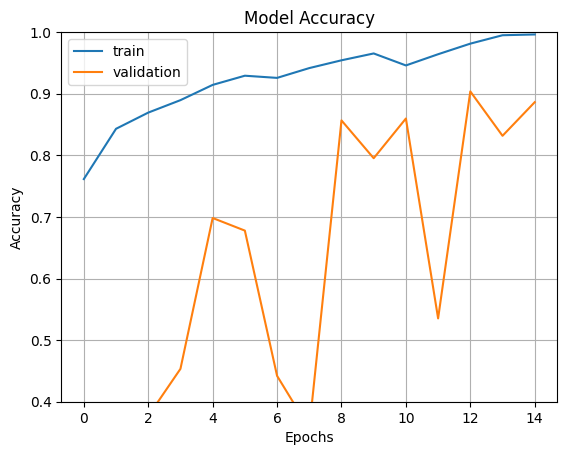

In [ ]:
# Evaluate the ResNet-50 model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


In [ ]:
# Model Inference
# Preprocess the sample image
import cv2
image = cv2.imread('Filtered_COVID_Dataset_7000/Normal/Normal-2.png')
image_resized = cv2.resize(image, (128, 128))
image = np.expand_dims(image_resized, axis=0)


# Make predictions
image_pred = model.predict(image)


# Produce a human-readable output label
image_output_class = covid_classes[np.argmax(image_pred)]
print("The predicted class is", image_output_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
The predicted class is Viral Pneumonia


# RESNET-50 Try different

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Define the model
def build_resnet_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model for transfer learning
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.2)(x)  # Dropout with 20% rate
    #  kernel_regularizer=l2(0.001)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)
    base_model.trainable=True

    # for layer in base_model.layers[:-30]:  # Freeze all layers except the top 30
    #   layer.trainable = False

    return model

# Initialize model
# model2 = build_resnet_model()
model2 = build_resnet_model(num_classes=6)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model structure
# model.summary()

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history2 = model2.fit(
    covid_train_generator,
    validation_data=covid_val_generator,
    epochs=7,
    class_weight=covid_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 3145s 12s/step - accuracy: 0.6804 - loss: 2.3605 - val_accuracy: 0.2654 - val_loss: 7.1050 - learning_rate: 0.0010
Epoch 2/7
248/248 ━━━━━━━━━━━━━━━━━━━━ 3168s 13s/step - accuracy: 0.8509 - loss: 0.6100 - val_accuracy: 0.3419 - val_loss: 4.4740 - learning_rate: 0.0010
Epoch 3/7
248/248 ━━━━━━━━━━━━━━━━━━━━ 3137s 13s/step - accuracy: 0.8629 - loss: 0.4462 - val_accuracy: 0.2699 - val_loss: 4.5696 - learning_rate: 0.0010
Epoch 4/7
115/248 ━━━━━━━━━━━━━━━━━━━━ 25:52 12s/step - accuracy: 0.8727 - loss: 0.4252

mnist

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history2 = model2.fit(
    mnist_train_generator,
    validation_data=mnist_val_generator,
    epochs=5,
    class_weight=mnist_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


263/263 ━━━━━━━━━━━━━━━━━━━━ 1504s 5s/step - accuracy: 0.8920 - loss: 0.4414 - val_accuracy: 0.1670 - val_loss: 14.7942 - learning_rate: 0.0010
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 52s 196ms/step - accuracy: 0.9833 - loss: 0.0760 - val_accuracy: 0.3091 - val_loss: 1.8067 - learning_rate: 0.0010
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 50s 188ms/step - accuracy: 0.9845 - loss: 0.0597 - val_accuracy: 0.4718 - val_loss: 1.4910 - learning_rate: 0.0010
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 50s 187ms/step - accuracy: 0.9764 - loss: 0.0815 - val_accuracy: 0.9479 - val_loss: 0.2094 - learning_rate: 0.0010
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.9871 - loss: 0.0519 - val_accuracy: 0.9336 - val_loss: 0.1939 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model2.evaluate(mnist_test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

 1/88 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.9375 - loss: 0.0549

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.9394 - loss: 0.1882
Test Loss: 0.16623035073280334, Test Accuracy: 0.9436116814613342


In [ ]:
model2.save("mnist-adam-99ac.keras")

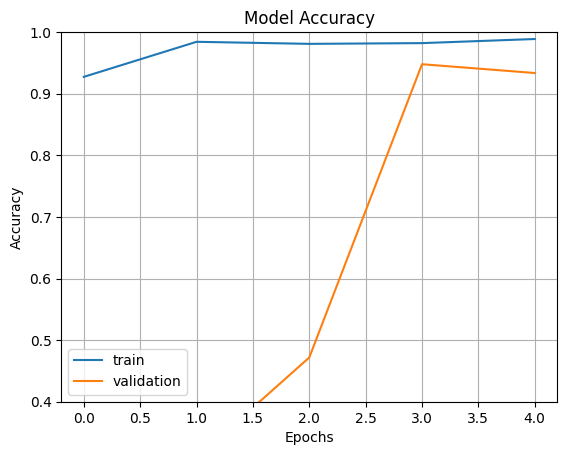

In [ ]:
# Evaluate the ResNet-50 model
fig1 = plt.gcf()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


nadam

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

def build_resnet_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model for transfer learning
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.2)(x)  # Dropout with 20% rate
    #  kernel_regularizer=l2(0.001)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)
    base_model.trainable=True

    # for layer in base_model.layers[:-30]:  # Freeze all layers except the top 30
    #   layer.trainable = False

    return model

# Initialize model
# model2 = build_resnet_model()
model3 = build_resnet_model(num_classes=6)
# Compile the model
model3.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history3 = model3.fit(
    mnist_train_generator,
    validation_data=mnist_val_generator,
    epochs=5,
    class_weight=mnist_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


263/263 ━━━━━━━━━━━━━━━━━━━━ 180s 340ms/step - accuracy: 0.9066 - loss: 0.4309 - val_accuracy: 0.1670 - val_loss: 3.9381 - learning_rate: 0.0010
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 51s 191ms/step - accuracy: 0.9894 - loss: 0.0368 - val_accuracy: 0.1670 - val_loss: 2.5868 - learning_rate: 0.0010
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 54s 205ms/step - accuracy: 0.9732 - loss: 0.0833 - val_accuracy: 0.3326 - val_loss: 2.4189 - learning_rate: 0.0010
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 78s 190ms/step - accuracy: 0.9964 - loss: 0.0105 - val_accuracy: 0.7637 - val_loss: 0.7677 - learning_rate: 0.0010
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 54s 203ms/step - accuracy: 0.9918 - loss: 0.0294 - val_accuracy: 0.3076 - val_loss: 15.8550 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model3.evaluate(mnist_test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

 2/88 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8438 - loss: 0.7161  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.7513 - loss: 0.7726
Test Loss: 0.7193989157676697, Test Accuracy: 0.7608850598335266


In [ ]:
model3.save("./nadam-mnist-99.keras")

In [ ]:
# Model Inference
# Preprocess the sample image
import cv2
image = cv2.imread('Filtered_COVID_Dataset_7000/Normal/Normal-2.png')
image_resized = cv2.resize(image, (128, 128))
image = np.expand_dims(image_resized, axis=0)


# Make predictions
image_pred = model2.predict(image)


# Produce a human-readable output label
image_output_class = covid_classes[np.argmax(image_pred)]
print("The predicted class is", image_output_class)

# Run all 4 models together here

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
img_h = 224
img_w = 224

In [ ]:
# Define the model
def build_resnet_model(input_shape=(img_h, img_w, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False  # Freeze the base model for transfer learning


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)

    base_model.trainable=True
    return model

# Initialize model
covid_adam_model = build_resnet_model()
covid_nadam_model = build_resnet_model()


In [ ]:
# Define the model
def build_resnet_model(input_shape=(img_h, img_w, 3), num_classes=6):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False  # Freeze the base model for transfer learning


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.2)(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)

    base_model.trainable=True
    return model

# Initialize model
mnist_adam_model = build_resnet_model()
mnist_nadam_model = build_resnet_model()

## COVID ADAM MODEL

In [ ]:
covid_adam_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

covid_adam_history = covid_adam_model.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])



Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.7143 - loss: 0.8246 - val_accuracy: 0.2654 - val_loss: 2.9182 - learning_rate: 0.0010
Epoch 2/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.8619 - loss: 0.4025 - val_accuracy: 0.2350 - val_loss: 1.5753 - learning_rate: 0.0010
Epoch 3/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - accuracy: 0.8506 - loss: 0.3987 - val_accuracy: 0.4678 - val_loss: 1.4887 - learning_rate: 0.0010
Epoch 4/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 197ms/step - accuracy: 0.8826 - loss: 0.3208 - val_accuracy: 0.5648 - val_loss: 1.6150 - learning_rate: 0.0010
Epoch 5/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 197ms/step - accuracy: 0.9043 - loss: 0.2734 - val_accuracy: 0.8499 - val_loss: 0.3936 - learning_rate: 0.0010
Epoch 6/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 196ms/step - accuracy: 0.9068 - loss: 0.2364 - val_accuracy: 0.5701 - val_loss: 1.7486 - learning_rate: 0.0010
Epoch 7/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 201ms/step - accuracy: 0.9354 - loss: 0

## COVID NADAM MODEL

In [ ]:
from keras.optimizers import Nadam
# covid_nadam_model = build_resnet_model()

# Compile the model with Nadam
covid_nadam_model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

covid_nadam_history = covid_nadam_model.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(covid_test_generator)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 148s 325ms/step - accuracy: 0.7043 - loss: 0.8425 - val_accuracy: 0.2654 - val_loss: 8.8738 - learning_rate: 0.0010
Epoch 2/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.8590 - loss: 0.4275 - val_accuracy: 0.2654 - val_loss: 5.4213 - learning_rate: 0.0010
Epoch 3/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.8768 - loss: 0.3399 - val_accuracy: 0.2919 - val_loss: 2.9049 - learning_rate: 0.0010
Epoch 4/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - accuracy: 0.8859 - loss: 0.3403 - val_accuracy: 0.4905 - val_loss: 1.6027 - learning_rate: 0.0010
Epoch 5/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.9148 - loss: 0.2287 - val_accuracy: 0.4435 - val_loss: 2.2379 - learning_rate: 0.0010
Epoch 6/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.9133 - loss: 0.2216 - val_accuracy: 0.7051 - val_loss: 0.7775 - learning_rate: 0.0010
Epoch 7/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - accuracy: 0.

## MNIST ADAM MODEL

In [ ]:
mnist_adam_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
mnist_adam_history = mnist_adam_model.fit(
    mnist_train_generator,
    validation_data=mnist_val_generator,
    epochs=10,
    class_weight=mnist_weights,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


263/263 ━━━━━━━━━━━━━━━━━━━━ 2325s 8s/step - accuracy: 0.8900 - loss: 0.6197 - val_accuracy: 0.1670 - val_loss: 37.4067 - learning_rate: 0.0010
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.9605 - loss: 0.1396 - val_accuracy: 0.2405 - val_loss: 6.1800 - learning_rate: 0.0010
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 82s 191ms/step - accuracy: 0.9873 - loss: 0.0336 - val_accuracy: 0.2805 - val_loss: 1.8903 - learning_rate: 0.0010
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - accuracy: 0.9842 - loss: 0.0654 - val_accuracy: 0.6210 - val_loss: 1.1905 - learning_rate: 0.0010
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.9887 - loss: 0.0446 - val_accuracy: 0.8444 - val_loss: 0.5513 - learning_rate: 0.0010
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 54s 203ms/step - accuracy: 0.9904 - loss: 0.0323 - val_accuracy: 0.9800 - val_loss: 0.1107 - learning_rate: 0.0010
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 79s 193ms/step - accuracy: 0.9954 - loss:

## MNIST NADAM MODEL

In [ ]:
mnist_nadam_model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
mnist_nadam_history = mnist_nadam_model.fit(
    mnist_train_generator,
    validation_data=mnist_val_generator,
    epochs=10,
    class_weight=mnist_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 150s 324ms/step - accuracy: 0.8874 - loss: 0.5166 - val_accuracy: 0.1670 - val_loss: 2.4879 - learning_rate: 0.0010
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.9831 - loss: 0.0649 - val_accuracy: 0.1670 - val_loss: 5.9505 - learning_rate: 0.0010
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.9878 - loss: 0.0666 - val_accuracy: 0.3498 - val_loss: 2.3144 - learning_rate: 0.0010
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 51s 192ms/step - accuracy: 0.9963 - loss: 0.0101 - val_accuracy: 0.9379 - val_loss: 0.1957 - learning_rate: 0.0010
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - accuracy: 0.9798 - loss: 0.1020 - val_accuracy: 0.8687 - val_loss: 0.4356 - learning_rate: 0.0010
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - accuracy: 0.9944 - loss: 0.0228 - val_accuracy: 0.9986 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 208ms/step - accuracy: 0.

## ALL TOGETHER GRAPH

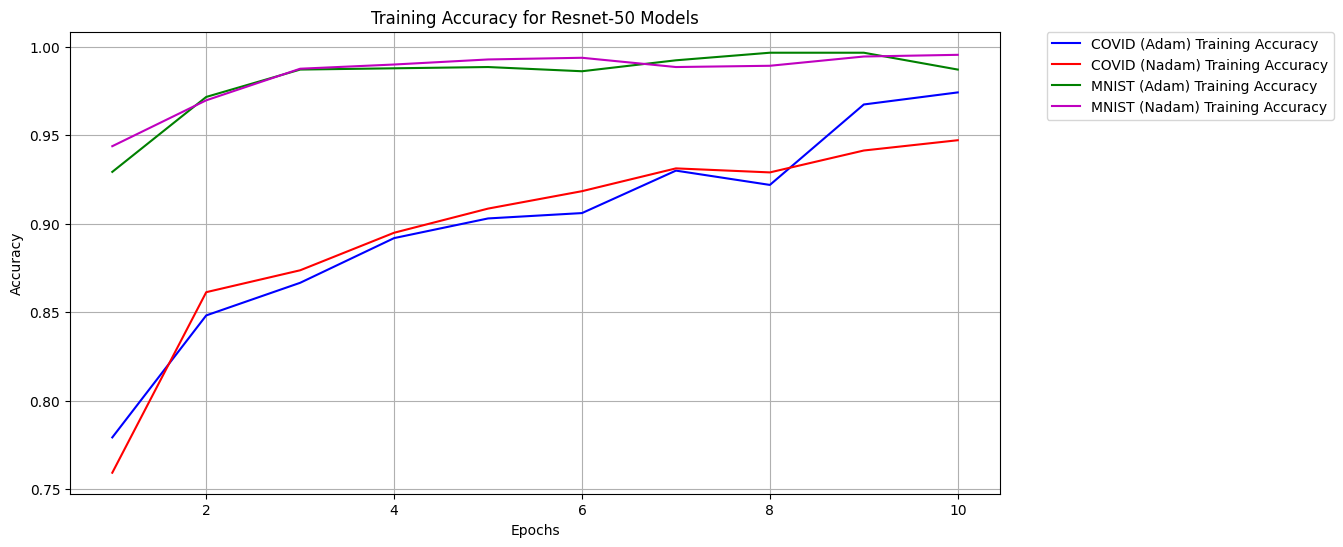

In [ ]:
def plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history):

    covid_adam_acc = covid_adam_history.history['accuracy']

    covid_nadam_acc = covid_nadam_history.history['accuracy']

    mnist_adam_acc = mnist_adam_history.history['accuracy']

    mnist_nadam_acc = mnist_nadam_history.history['accuracy']

    epochs = range(1, len(covid_adam_acc) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, covid_adam_acc[:10], 'b-', label='COVID (Adam) Training Accuracy')
    plt.plot(epochs, covid_nadam_acc[:10], 'r-', label='COVID (Nadam) Training Accuracy')
    plt.plot(epochs, mnist_adam_acc[:10], 'g-', label='MNIST (Adam) Training Accuracy')
    plt.plot(epochs, mnist_nadam_acc[:10], 'm-', label='MNIST (Nadam) Training Accuracy')
    plt.title('Training Accuracy for Resnet-50 Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()

plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history)


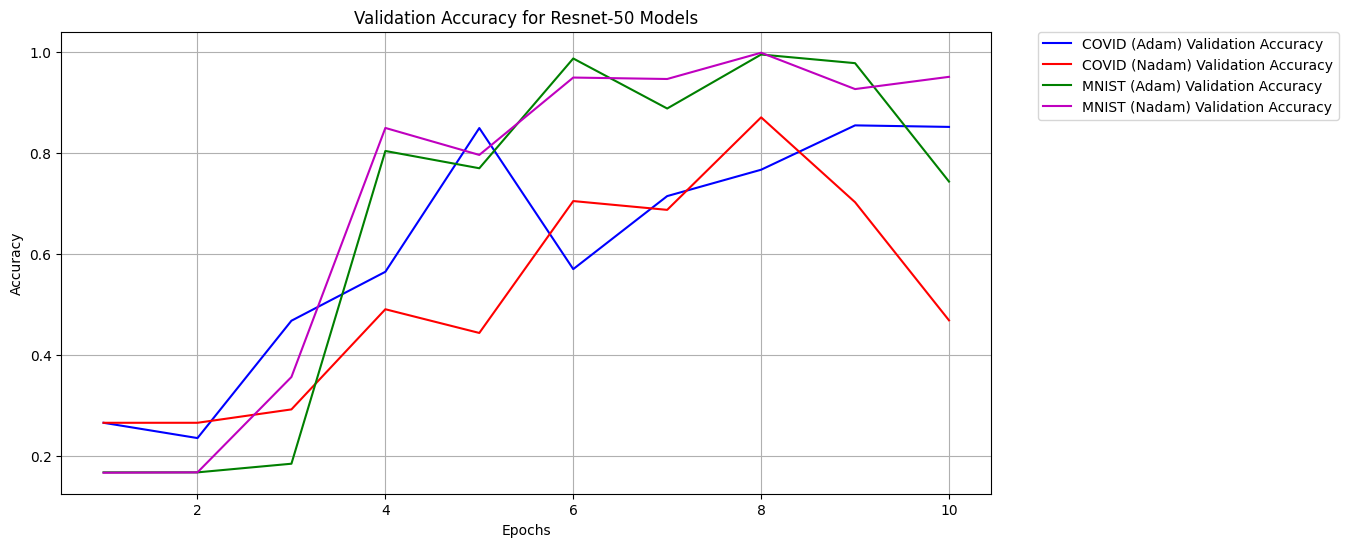

In [ ]:
def plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history):

    covid_adam_acc = covid_adam_history.history['val_accuracy']

    covid_nadam_acc = covid_nadam_history.history['val_accuracy']

    mnist_adam_acc = mnist_adam_history.history['val_accuracy']

    mnist_nadam_acc = mnist_nadam_history.history['val_accuracy']

    epochs = range(1, len(covid_adam_acc) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, covid_adam_acc[:10], 'b-', label='COVID (Adam) Validation Accuracy')
    plt.plot(epochs, covid_nadam_acc[:10], 'r-', label='COVID (Nadam) Validation Accuracy')
    plt.plot(epochs, mnist_adam_acc[:10], 'g-', label='MNIST (Adam) Validation Accuracy')
    plt.plot(epochs, mnist_nadam_acc[:10], 'm-', label='MNIST (Nadam) Validation Accuracy')
    plt.title('Validation Accuracy for Resnet-50 Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()

plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history)


In [ ]:
covid_adam_model.save("./Snigdha/covid-adam-98.keras")
covid_nadam_model.save("./Snigdha/covid-nadam-96.keras")
mnist_adam_model.save("./Snigdha/mnist-adam-9969.keras")
mnist_nadam_model.save("./Snigdha/mnist-nadam-9920.keras")


In [ ]:
def eval_adv():
    covid_adam_test_loss, covid_adam_test_accuracy = covid_adam_model.evaluate(covid_test_generator)
    print(f"COVID Model (Adam) - Test Loss: {covid_adam_test_loss:.4f}, Test Accuracy: {covid_adam_test_accuracy:.4f}")

    covid_nadam_test_loss, covid_nadam_test_accuracy = covid_nadam_model.evaluate(covid_test_generator)
    print(f"COVID Model (Nadam) - Test Loss: {covid_nadam_test_loss:.4f}, Test Accuracy: {covid_nadam_test_accuracy:.4f}")

    mnist_adam_test_loss, mnist_adam_test_accuracy = mnist_adam_model.evaluate(mnist_test_generator)
    print(f"MNIST Model (Adam) - Test Loss: {mnist_adam_test_loss:.4f}, Test Accuracy: {mnist_adam_test_accuracy:.4f}")

    mnist_nadam_test_loss, mnist_nadam_test_accuracy = mnist_nadam_model.evaluate(mnist_test_generator)
    print(f"MNIST Model (Nadam) - Test Loss: {mnist_nadam_test_loss:.4f}, Test Accuracy: {mnist_nadam_test_accuracy:.4f}")
eval_adv()

NameError: name 'covid_adam_model' is not defined

# TRY DIFFERENT

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
img_w = 224
img_h = 224

## covid with adam

In [ ]:
# Define the model
def build_resnet_model(input_shape=(img_h, img_w, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    # for layer in base_model.layers[:143]:
    #     layer.trainable = False
    base_model.trainable = False  # Freeze the base model for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)
    base_model.trainable=True
    return model

# Initialize model
model = build_resnet_model()
# check_point = K.callbacks.ModelCheckpoint(filepath = "",monitor="val_acc", mode="max",save_best_only=True,)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 2395s 9s/step - accuracy: 0.6763 - loss: 0.8994 - val_accuracy: 0.2039 - val_loss: 4.3796 - learning_rate: 0.0010
Epoch 2/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.8144 - loss: 0.4900 - val_accuracy: 0.2654 - val_loss: 1.4503 - learning_rate: 0.0010
Epoch 3/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.8548 - loss: 0.4013 - val_accuracy: 0.4807 - val_loss: 1.2558 - learning_rate: 0.0010
Epoch 4/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 77s 199ms/step - accuracy: 0.8771 - loss: 0.3469 - val_accuracy: 0.4860 - val_loss: 2.6268 - learning_rate: 0.0010
Epoch 5/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 52s 207ms/step - accuracy: 0.8832 - loss: 0.3117 - val_accuracy: 0.7983 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 6/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 204ms/step - accuracy: 0.9100 - loss: 0.2484 - val_accuracy: 0.3541 - val_loss: 9.7238 - learning_rate: 0.0010
Epoch 7/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 94s 255ms/step - accuracy: 0.9198 - loss: 

## covid with nadam

In [ ]:
model2 =  build_resnet_model()
# check_point = K.callbacks.ModelCheckpoint(filepath = "",monitor="val_acc", mode="max",save_best_only=True,)
model2.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history2 = model2.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 169s 398ms/step - accuracy: 0.6783 - loss: 0.8876 - val_accuracy: 0.2654 - val_loss: 5.2302 - learning_rate: 0.0010
Epoch 2/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 63s 203ms/step - accuracy: 0.8421 - loss: 0.4552 - val_accuracy: 0.2654 - val_loss: 13.2357 - learning_rate: 0.0010
Epoch 3/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 85s 215ms/step - accuracy: 0.8730 - loss: 0.3638 - val_accuracy: 0.4625 - val_loss: 1.6329 - learning_rate: 0.0010
Epoch 4/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 197ms/step - accuracy: 0.9042 - loss: 0.2630 - val_accuracy: 0.2661 - val_loss: 11.6623 - learning_rate: 0.0010
Epoch 5/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.8993 - loss: 0.2681 - val_accuracy: 0.4155 - val_loss: 2.4339 - learning_rate: 0.0010
Epoch 6/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.9337 - loss: 0.2102 - val_accuracy: 0.7688 - val_loss: 0.8006 - learning_rate: 0.0010
Epoch 7/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 212ms/step - accuracy: 

## Get Graphs all 4

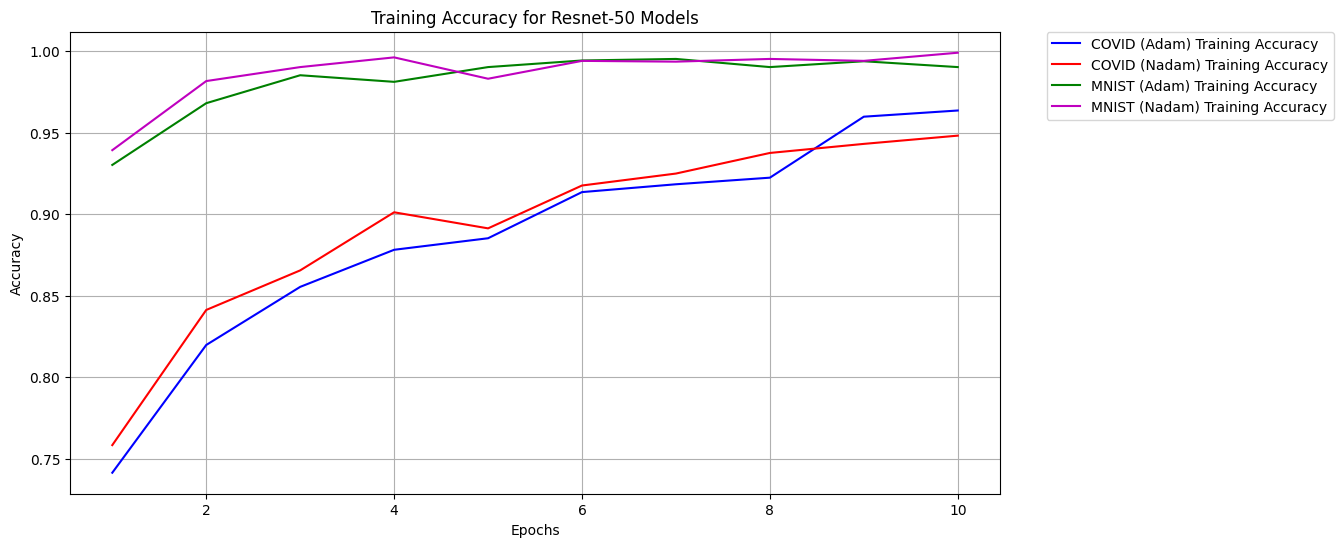

In [ ]:
def plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history):

    covid_adam_acc = covid_adam_history.history['accuracy']

    covid_nadam_acc = covid_nadam_history.history['accuracy']

    mnist_adam_acc = mnist_adam_history.history['accuracy']

    mnist_nadam_acc = mnist_nadam_history.history['accuracy']

    epochs = range(1, len(covid_adam_acc) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, covid_adam_acc[:10], 'b-', label='COVID (Adam) Training Accuracy')
    plt.plot(epochs, covid_nadam_acc[:10], 'r-', label='COVID (Nadam) Training Accuracy')
    plt.plot(epochs, mnist_adam_acc[:10], 'g-', label='MNIST (Adam) Training Accuracy')
    plt.plot(epochs, mnist_nadam_acc[:10], 'm-', label='MNIST (Nadam) Training Accuracy')
    plt.title('Training Accuracy for Resnet-50 Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()

plot_adv(history, history2, mnist_adam_history, mnist_nadam_history)

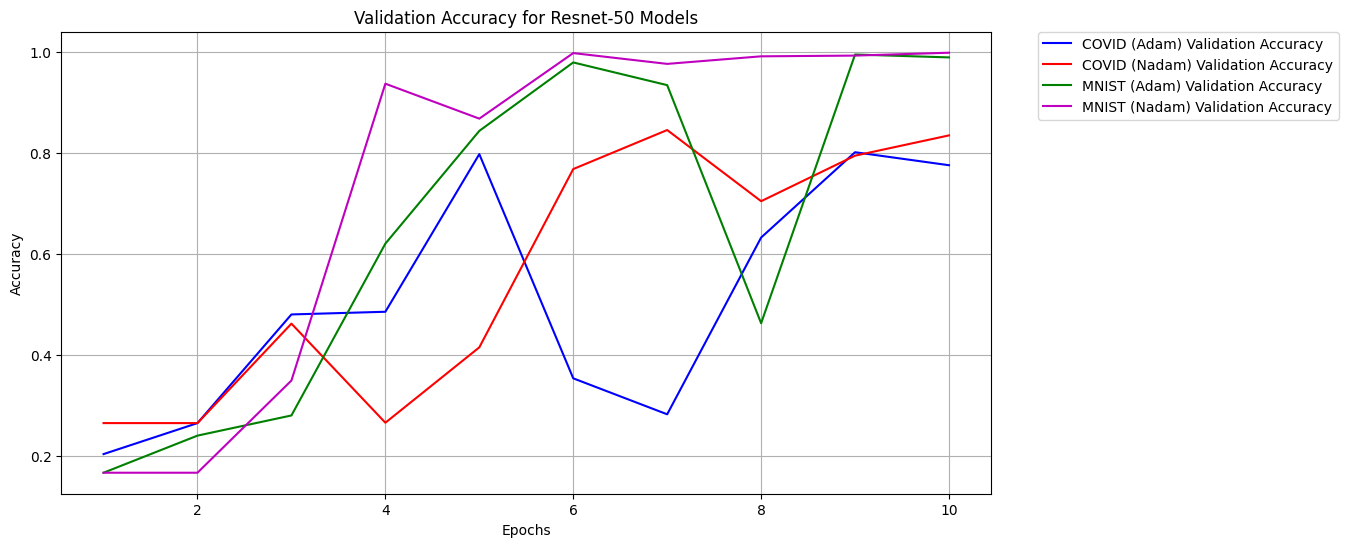

In [ ]:
def plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history):

    covid_adam_acc = covid_adam_history.history['val_accuracy']

    covid_nadam_acc = covid_nadam_history.history['val_accuracy']

    mnist_adam_acc = mnist_adam_history.history['val_accuracy']

    mnist_nadam_acc = mnist_nadam_history.history['val_accuracy']

    epochs = range(1, len(covid_adam_acc) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, covid_adam_acc[:10], 'b-', label='COVID (Adam) Validation Accuracy')
    plt.plot(epochs, covid_nadam_acc[:10], 'r-', label='COVID (Nadam) Validation Accuracy')
    plt.plot(epochs, mnist_adam_acc[:10], 'g-', label='MNIST (Adam) Validation Accuracy')
    plt.plot(epochs, mnist_nadam_acc[:10], 'm-', label='MNIST (Nadam) Validation Accuracy')
    plt.title('Validation Accuracy for Resnet-50 Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()

plot_adv(history, history2, mnist_adam_history, mnist_nadam_history)

## COVID ADAM DIFFERENT with l2

In [ ]:
# Define the model
def build_resnet_model(input_shape=(img_h, img_w, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    # for layer in base_model.layers[:143]:
    #     layer.trainable = False
    base_model.trainable = False  # Freeze the base model for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu',  kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)
    base_model.trainable=True
    return model

covid_model1 = build_resnet_model()
covid_model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

covid_history = covid_model1.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 140s 334ms/step - accuracy: 0.6700 - loss: 2.4809 - val_accuracy: 0.2654 - val_loss: 4.5878 - learning_rate: 0.0010
Epoch 2/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 52s 207ms/step - accuracy: 0.8488 - loss: 0.6587 - val_accuracy: 0.2654 - val_loss: 2.8597 - learning_rate: 0.0010
Epoch 3/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 80s 201ms/step - accuracy: 0.8754 - loss: 0.4210 - val_accuracy: 0.2767 - val_loss: 3.7275 - learning_rate: 0.0010
Epoch 4/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.8912 - loss: 0.3535 - val_accuracy: 0.5064 - val_loss: 1.8054 - learning_rate: 0.0010
Epoch 5/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.9015 - loss: 0.3185 - val_accuracy: 0.6217 - val_loss: 0.8294 - learning_rate: 0.0010
Epoch 6/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - accuracy: 0.9201 - loss: 0.2553 - val_accuracy: 0.6414 - val_loss: 1.1832 - learning_rate: 0.0010
Epoch 7/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - accuracy: 0.

In [ ]:
covid_model2 = build_resnet_model()
covid_model2.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

covid_history2 = covid_model2.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 156s 345ms/step - accuracy: 0.7056 - loss: 2.3435 - val_accuracy: 0.2654 - val_loss: 2.6548 - learning_rate: 0.0010
Epoch 2/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 201ms/step - accuracy: 0.8615 - loss: 0.6110 - val_accuracy: 0.2039 - val_loss: 3.8413 - learning_rate: 0.0010
Epoch 3/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - accuracy: 0.8789 - loss: 0.4133 - val_accuracy: 0.2775 - val_loss: 3.4961 - learning_rate: 0.0010
Epoch 4/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.8898 - loss: 0.3533 - val_accuracy: 0.7187 - val_loss: 0.7025 - learning_rate: 0.0010
Epoch 5/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 85s 211ms/step - accuracy: 0.9241 - loss: 0.2731 - val_accuracy: 0.4473 - val_loss: 6.3125 - learning_rate: 0.0010
Epoch 6/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 79s 199ms/step - accuracy: 0.9168 - loss: 0.2578 - val_accuracy: 0.8362 - val_loss: 0.5241 - learning_rate: 0.0010
Epoch 7/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 85s 210ms/step - accuracy: 0.

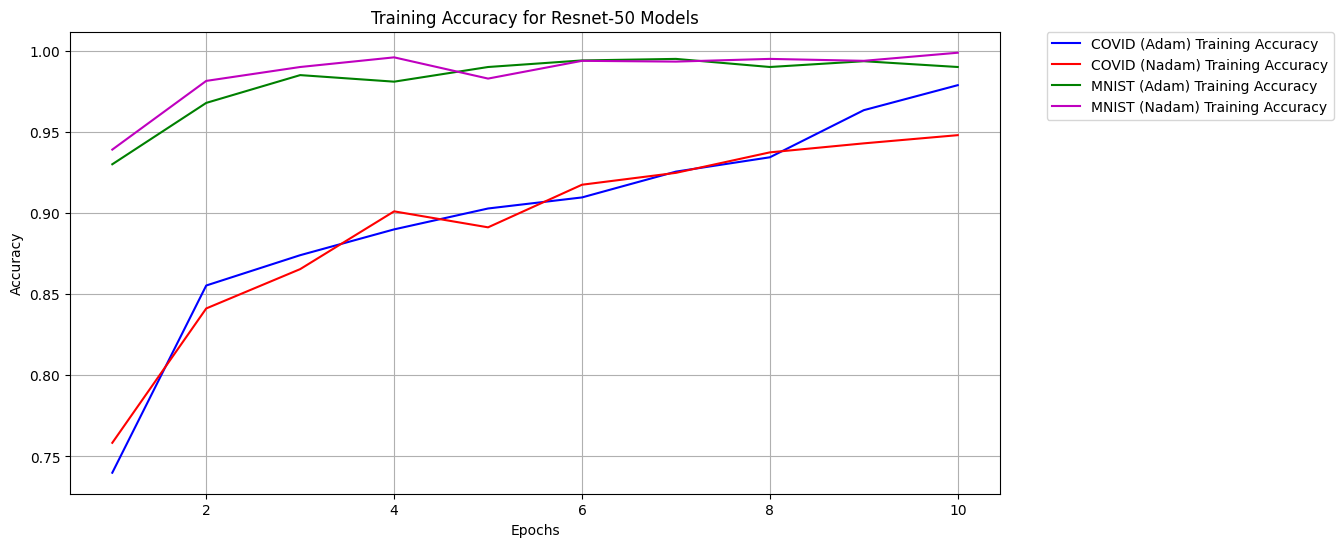

In [ ]:
def plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history):

    covid_adam_acc = covid_adam_history.history['accuracy']

    covid_nadam_acc = covid_nadam_history.history['accuracy']

    mnist_adam_acc = mnist_adam_history.history['accuracy']

    mnist_nadam_acc = mnist_nadam_history.history['accuracy']

    # epochs = range(1, len(covid_adam_acc) + 1)
    epochs = range(1,11)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, covid_adam_acc[:10], 'b-', label='COVID (Adam) Training Accuracy')
    plt.plot(epochs, covid_nadam_acc[:10], 'r-', label='COVID (Nadam) Training Accuracy')
    plt.plot(epochs, mnist_adam_acc[:10], 'g-', label='MNIST (Adam) Training Accuracy')
    plt.plot(epochs, mnist_nadam_acc[:10], 'm-', label='MNIST (Nadam) Training Accuracy')
    plt.title('Training Accuracy for Resnet-50 Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()

plot_adv(covid_history, history2, mnist_adam_history, mnist_nadam_history)

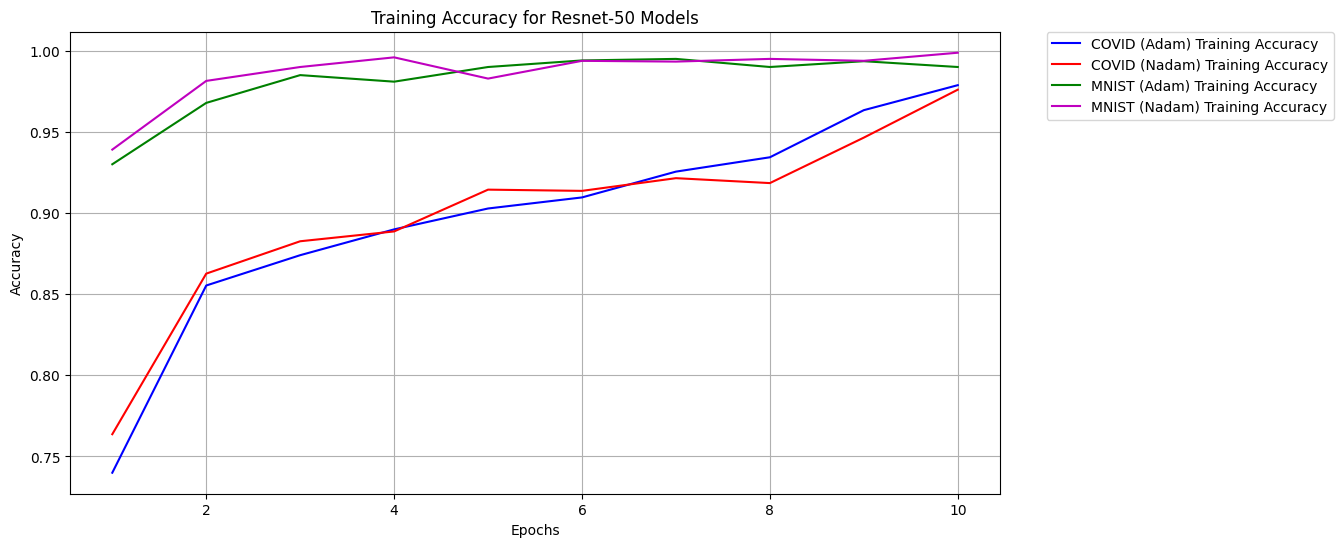

In [ ]:
def plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history):

    covid_adam_acc = covid_adam_history.history['accuracy']

    covid_nadam_acc = covid_nadam_history.history['accuracy']

    mnist_adam_acc = mnist_adam_history.history['accuracy']

    mnist_nadam_acc = mnist_nadam_history.history['accuracy']

    # epochs = range(1, len(covid_adam_acc) + 1)
    epochs = range(1,11)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, covid_adam_acc[:10], 'b-', label='COVID (Adam) Training Accuracy')
    plt.plot(epochs, covid_nadam_acc[:10], 'r-', label='COVID (Nadam) Training Accuracy')
    plt.plot(epochs, mnist_adam_acc[:10], 'g-', label='MNIST (Adam) Training Accuracy')
    plt.plot(epochs, mnist_nadam_acc[:10], 'm-', label='MNIST (Nadam) Training Accuracy')
    plt.title('Training Accuracy for Resnet-50 Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()

plot_adv(covid_history, covid_history2, mnist_adam_history, mnist_nadam_history)

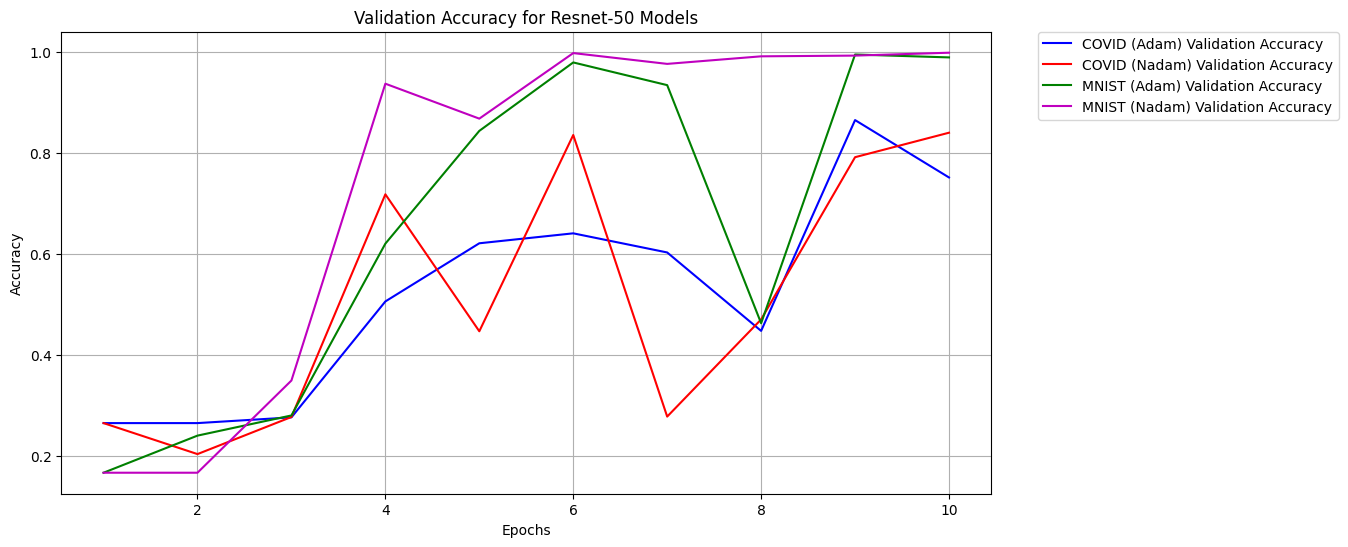

In [ ]:
def plot_adv(covid_adam_history, covid_nadam_history, mnist_adam_history, mnist_nadam_history):

    covid_adam_acc = covid_adam_history.history['val_accuracy']

    covid_nadam_acc = covid_nadam_history.history['val_accuracy']

    mnist_adam_acc = mnist_adam_history.history['val_accuracy']

    mnist_nadam_acc = mnist_nadam_history.history['val_accuracy']

    epochs = range(1, len(covid_adam_acc))
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, covid_adam_acc[:10], 'b-', label='COVID (Adam) Validation Accuracy')
    plt.plot(epochs, covid_nadam_acc[:10], 'r-', label='COVID (Nadam) Validation Accuracy')
    plt.plot(epochs, mnist_adam_acc[:10], 'g-', label='MNIST (Adam) Validation Accuracy')
    plt.plot(epochs, mnist_nadam_acc[:10], 'm-', label='MNIST (Nadam) Validation Accuracy')
    plt.title('Validation Accuracy for Resnet-50 Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.show()

plot_adv(covid_history, covid_history2, mnist_adam_history, mnist_nadam_history)